At first,I need to install the "duckduckgo_search" package

In [1]:
# Skip this cell if you already have duckduckgo_search installed
!pip install -Uqq duckduckgo_search

Then I use the "duckduckgo_search" and "fastcore" libraries to define a function that searches for images using the DuckDuckGo search engine.

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *
def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')


I use the "search_images" function that was defined earlier to search for bird photos.And the maximum number of images to retrieve is set to 1. 
I just get the first image of the "urls" list to have a look with this code.

In [4]:
urls = search_images('bird photos', max_images=1)
urls[0]

/home/vscode/.local/lib/python3.10/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/home/vscode/.local/lib/python3.10/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/home/vscode/.local/lib/python3.10/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


'http://www.wallpapergeeks.com/wp-content/uploads/2014/02/Colorful-Bird-Perched-Wallpaper.jpg'

I use the "fastdownload" python library to download an image from the internet and save it to a local file. 

In [5]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)


Path('bird.jpg')

I use the "fastai" library to open an image file and create a thumbnail from it.

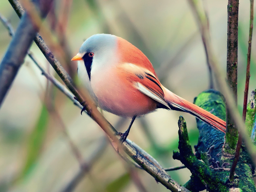

In [6]:
from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)


I repeat the steps before to performing a DuckDuckGo image search, downloading an horse image from the search results, and then creating a thumbnail from that image.

/home/vscode/.local/lib/python3.10/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/home/vscode/.local/lib/python3.10/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/home/vscode/.local/lib/python3.10/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


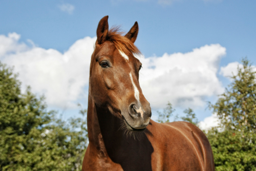

In [7]:
download_url(search_images('horse photos', max_images=1)[0], 'horse.jpg', show_progress=False)
Image.open('horse.jpg').to_thumb(256,256)

I set up ten variables which correspond to ten animals,for image download and image classification task later

In [8]:
searches = 'bird','horse','dolphin','panda','tiger','lion','dog','cat','koala','kangaroo'
path = Path('bird_or_not')
from time import sleep

I download the images of ten animals fron the library,and then classify these photos to two categories,one is the photo that show the animal in the zoo,the other is to show wild animal.

In [8]:
for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} zoo photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} wild photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

/home/vscode/.local/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/vscode/.local/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


I use the "fastai"library to validate the downloaded images and remove any files that couldn't be opened as images. 

In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)


116

In this step,I establish a model with "dataloaders",dataloaders is a object that contains a training set and a validation set.In this place,our input is image and output is category.We can get image from corresponding folder and set 20 percent of the dataset as validation set.

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

Then I display 20 images from the dataset.

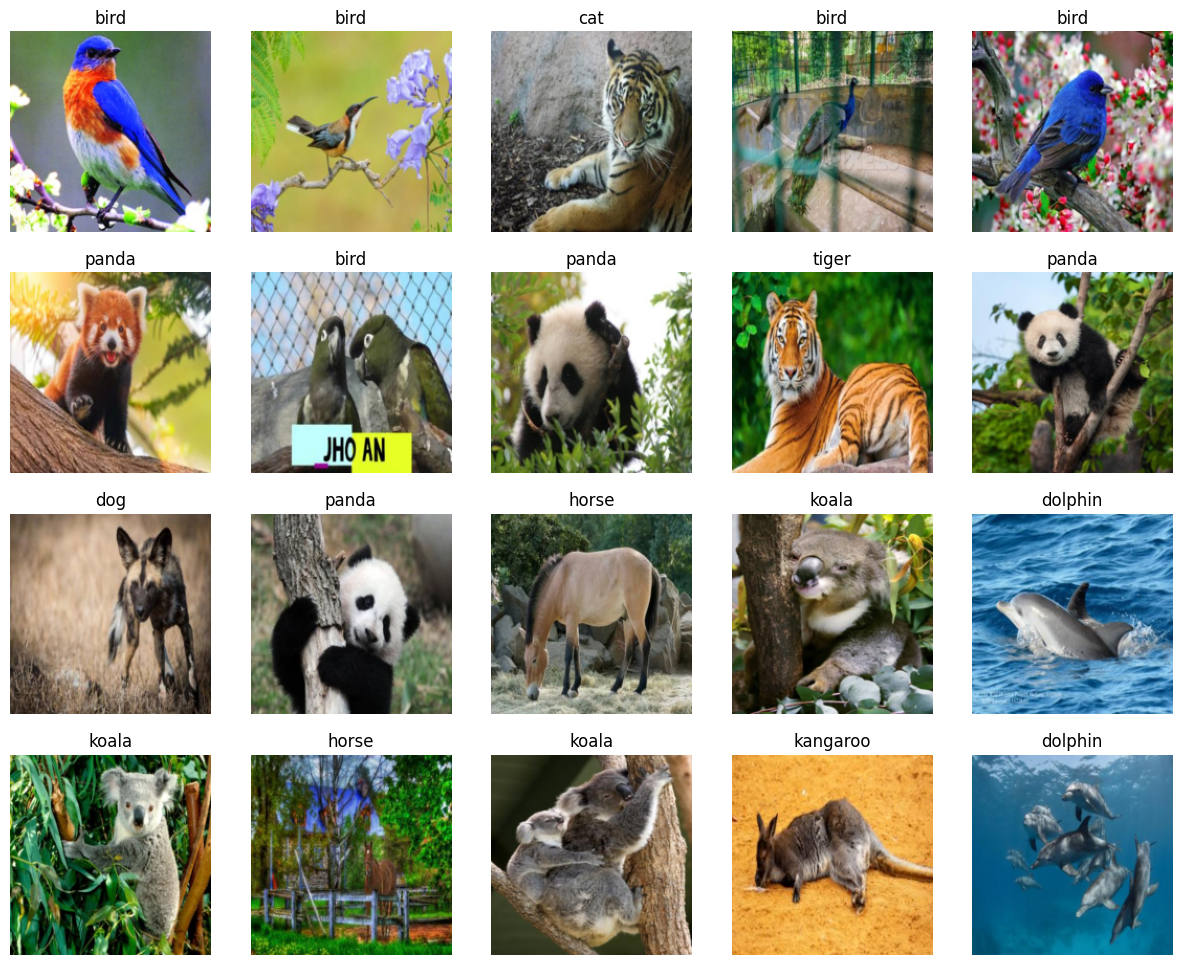

In [10]:
dls.show_batch(max_n=20)

use fine-tune to train my model,During fine-tuning, the last layers of the model are trained first, and then the entire model is trained. This can often lead to better performance when using pre-trained models.

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/home/vscode/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In this step we create a confusion matrix to interpret the training result.In this place,the y-axis is the actual animal we get,the x-axis is the animal that we predict.The figure in the diagonal position shows how many right results we have got,the number in other position shows how mang wrong matches we get.For example,in the first column,we predict the animal is a bird,after testing the images,we can get 321 bird images,but we also get 3 cat images,1 horse image,2 koala image and 1 tiger image.This is the function of this confusion matrix. 

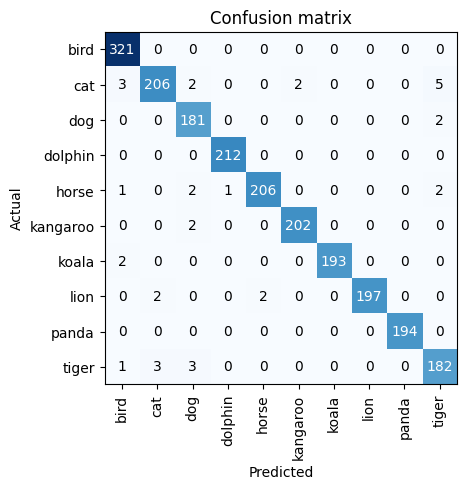

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


show the five images with highest loss in validation set from the model:

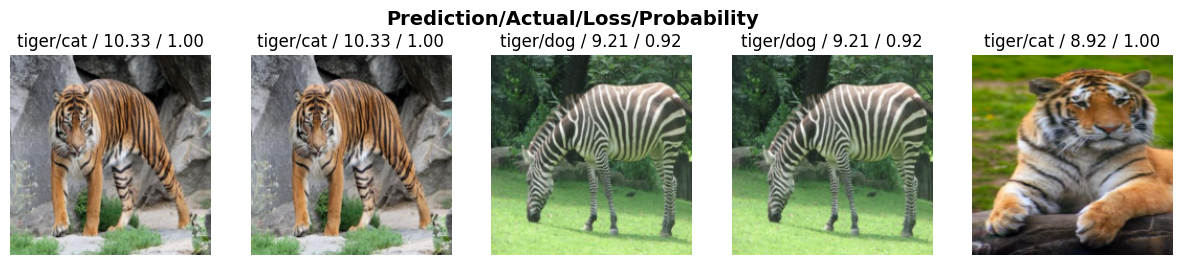

In [14]:
interp.plot_top_losses(5, nrows=1)

In this place,I use the model to predict the class of a new image and then print out the prediction and the associated probability.

In [13]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000
